In [1]:
from airfoil import Airfoil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from panel_method import define_panels, Freestream, build_matrix, build_rhs, get_tangential_velocity, get_pressure_coefficient
from itertools import chain

# Método dos Painéis

In [2]:
c = 1

In [3]:
airfoil = pd.read_csv('./airfoils/0012_airfoil_0_degrees.csv')

In [4]:
from datetime import datetime
time = datetime.now()
time = datetime.now() - time
time

datetime.timedelta(microseconds=34)

In [5]:
span = 5
N = 10
section_length = span / (N-1)
S = section_length * c

In [6]:
rho = 1.225
u_inf = 10
alpha = 5 * np.ones(N)
freestream = [Freestream(u_inf, a) for a in alpha]
Npanels = 200

In [7]:
a = [Airfoil('4412', a, Npanels*100, c) for a in alpha]

In [8]:
x = np.array(a[0].X_r)
y = np.array(a[0].Y_r)

In [9]:
E = 70 * 10e9
G = 26.5 * 10e9
I = 0.036 * c * a[0].t * (a[0].t**2 + a[0].h**2)
d = a[0].t / 2
J = np.pi * d ** 4/32
e = 0.1 * c

Text(0, 0.5, 'Y')

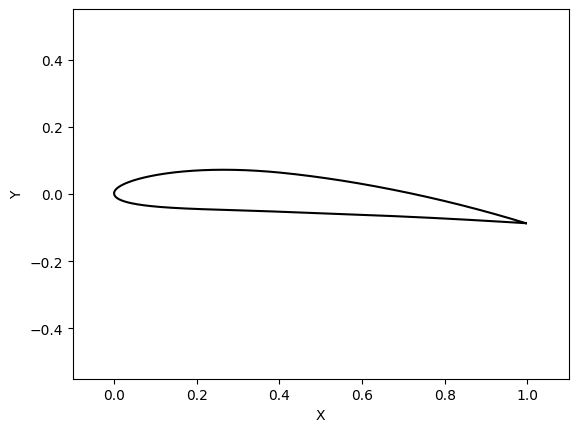

In [10]:
plt.plot(x, y, color = 'black')
plt.xlim(-.1, 1.1)
plt.ylim(-.55, .55)
plt.xlabel('X')
plt.ylabel('Y')

(-0.02, 0.02)

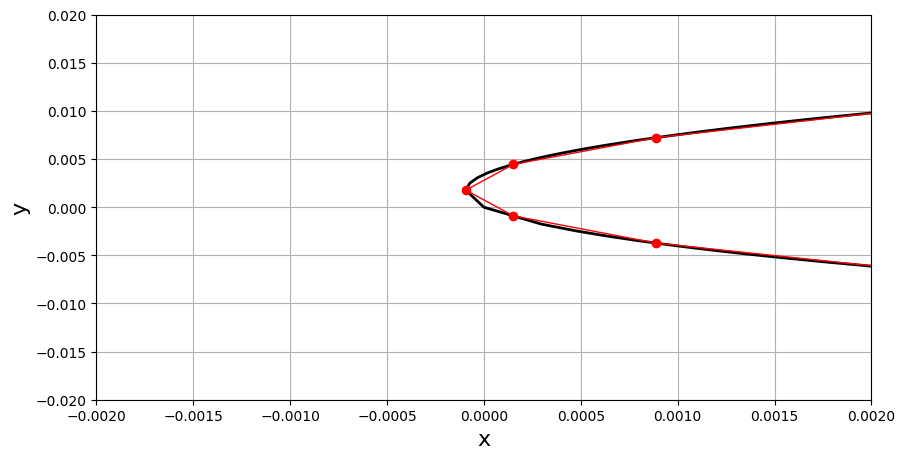

In [11]:
panels = [define_panels(x, y, Npanels) for _ in range(N)]

width = 10
plt.figure(figsize=(width, width/2))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels[0]], panels[0][0].xa),
            np.append([panel.ya for panel in panels[0]], panels[0][0].ya),
            linewidth=1, marker='o', markersize=6, color='red')
plt.xlim(-.002, .002)
plt.ylim(-.02, .02)

(-0.2, 0.2)

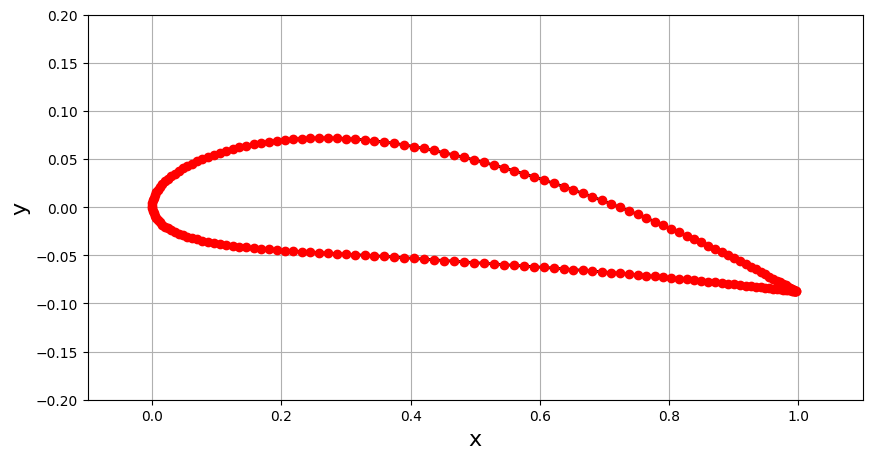

In [12]:
width = 10
plt.figure(figsize=(width, width/2))
plt.grid()
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.plot(x, y, color='k', linewidth=2)
plt.plot(np.append([panel.xa for panel in panels[0]], panels[0][0].xa),
            np.append([panel.ya for panel in panels[0]], panels[0][0].ya),
            linewidth=1, marker='o', markersize=6, color='red')
plt.xlim(-.1, 1.1)
plt.ylim(-.2, .2)

In [13]:
A = [build_matrix(p) for p in panels]
B = [build_rhs(p, f) for f in freestream for p in panels]

In [14]:
variables = [np.linalg.solve(a, b) for (a,b) in zip(A,B)]

for p in panels:
	for i, panel in enumerate(p):
		panel.sigma = variables[0][i]
	gamma = [v[-1] for v in variables]

In [15]:
for p in panels:
    for (f,g) in zip(freestream, gamma):
        get_tangential_velocity(p, f, g)

In [16]:
for p in panels:
    for f in freestream:
        get_pressure_coefficient(p, f)

Text(0.5, 1.0, 'Number of panels : 200')

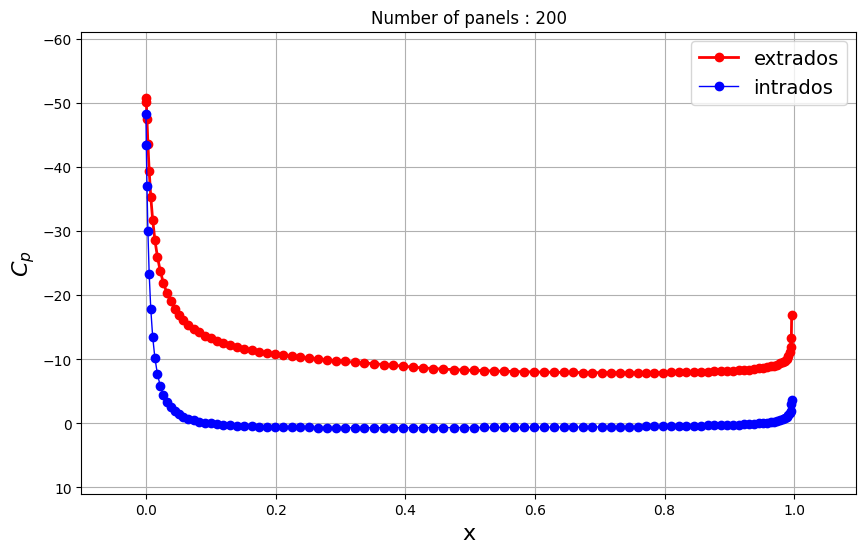

In [17]:
val_x, val_y = 0.1, 0.2
x_min, x_max = min(panel.xa for panel in panels[0] ), max( panel.xa for panel in panels[0])
cp_min, cp_max = min( panel.cp for panel in panels[0] ), max( panel.cp for panel in panels[0] )
x_start, x_end = x_min-val_x*(x_max-x_min), x_max+val_x*(x_max-x_min)
y_start, y_end = cp_min-val_y*(cp_max-cp_min), cp_max+val_y*(cp_max-cp_min)

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('x', fontsize=16)
plt.ylabel('$C_p$', fontsize=16)
plt.plot([panel.xc for panel in panels[0] if panel.loc == 'extrados'], 
         [panel.cp for panel in panels[0] if panel.loc == 'extrados'], 
         color='r', linewidth=2, marker='o', markersize=6)
plt.plot([panel.xc for panel in panels[0] if panel.loc == 'intrados'], 
         [panel.cp for panel in panels[0] if panel.loc == 'intrados'], 
         color='b', linewidth=1, marker='o', markersize=6)
plt.legend(['extrados', 'intrados'], loc='best', prop={'size':14})
plt.xlim(x_start, x_end)
plt.ylim(y_start, y_end)
plt.gca().invert_yaxis()
plt.title('Number of panels : %d' % Npanels)

In [18]:
Cl = []
for (f,g,p) in zip(freestream, gamma, panels):
    Cl.append(g*sum(panel.length for panel in p)/(0.5*f.u_inf*(x_max-x_min)))

In [19]:
Cm = []
for p in panels:
    Cm.append(sum(panel.cp*(panel.xc-0.25)*panel.length*np.cos(panel.beta) for panel in p))

In [20]:
L = [cl * S * rho * u_inf ** 2 * 0.5 for cl in Cl]

In [21]:
M = [cm * S * rho * u_inf ** 2 * 0.5 for cm in Cm]

In [22]:
T = [m + e*l for (l,m) in zip(L, M)]

# Método dos Elementos Finitos

In [23]:
k = np.asarray([[12*E*I/section_length**3, 6*E*I/section_length**2, 0, 12*E*I/section_length**3, 6*E*I/section_length**2, 0 ],
     [6*E*I/section_length**2, 4*E*I/section_length, 0, -6*E*I/section_length**2, 2*E*I/section_length, 0],
     [0, 0, G*J/section_length, 0, 0, -G*J/section_length],
     [-12*E*I/section_length**3, -6*E*I/section_length**2, 0, 12*E*I/section_length**3, -6*E*I/section_length**2, 0],
     [6*E*I/section_length**2, 2*E*I/section_length, 0 , -6*E*I/section_length**2, 4*E*I/section_length, 0],
     [0, 0, -G*J/section_length, 0, 0, G*J/section_length]], dtype=np.float32)

In [24]:
K = np.zeros(((N)*3,(N)*3))

for m in range(N-1):
    for i in range(len(k[0])):
        for j in range(len(k[1])):
            K[i+3*m,j+3*m] += k[i,j]

In [25]:
Mf = [l*s for (l,s) in zip(L, range(N))]

In [26]:
F = np.array(list((chain.from_iterable(zip(L, Mf, T)))))

In [27]:
d_known = np.array([0, 0, 0])
known_indices = np.array([0, 1, 2])
unknown_indices = np.setdiff1d(np.arange(len(F)), known_indices)

In [28]:
Kkk = K[np.ix_(known_indices, known_indices)]
Kku = K[np.ix_(known_indices, unknown_indices)]
Kuk = K[np.ix_(unknown_indices, known_indices)]
Kuu = K[np.ix_(unknown_indices, unknown_indices)]

In [29]:
Fk = F[known_indices]
Fu = F[unknown_indices]

In [30]:
d_unknown = np.linalg.solve(Kuu, Fu - np.dot(Kuk, d_known))

In [31]:
d_full = np.zeros(len(F))
d_full[known_indices] = d_known
d_full[unknown_indices] = d_unknown

In [32]:
# Calcular deslocamento rad to deg e criar loop até conversão ou divergência

In [33]:
d_torsion = d_full[2:N*3:3] * 180/np.pi